In [603]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels as sm

In [653]:
tickers = [
    "BTC-USD", "ETH-USD", "SOL-USD", "XRP-USD", "DOGE-USD",
    "BNB-USD", "LINK-USD", "ADA-USD", "AVAX-USD", "TRX-USD",
    "AAVE-USD", "OKB-USD", "WETH-USD", "GAME-USD", "ENA-USD"
]
start_ts = '2022-01-01'
end_ts = '2025-08-23'

data = yf.download(tickers=tickers, start=start_ts, end= end_ts, auto_adjust=False).dropna()
px = data['Adj Close']

[*********************100%***********************]  15 of 15 completed


In [654]:
px.index[0] #i.e. startdate

Timestamp('2024-04-02 00:00:00')

Parameters

In [655]:
starting_long = 1e+4
starting_short = 1e+4
rebalance_interval = 1 # daily

In [656]:
def construct_port(px, starting_cash=1e4, interval=1):
    n_assets = len(px.columns)
    standard_wt = 1 / n_assets
    current_cash = 0

    # Initialize portfolio: equal allocation 
    initial_allocation = starting_cash * standard_wt
    product_port = pd.DataFrame(
        [[initial_allocation / px.iloc[0][col] for col in px.columns]],
        columns=px.columns,
        index=[px.index[0]]
    )
    product_port['Position Size'] = starting_cash

    trades = []

    def calculate_wts(port, px, i):
        value = port.iloc[-1] * px.iloc[i]
        total = value.sum()
        return value / total

    # create set of dates to check
    dates = set(px.index[::interval])

    for i in range(1, len(px)):
        temp_port = product_port.iloc[[-1]].copy()  # start from yesterday's holdings
        temp_port.index = [px.index[i]]
        wts = calculate_wts(product_port, px, i)

        # Rebalance only if weights are not equal on days in dates (set)
        if (wts.nunique() != 1) and (px.index[i] in dates):
            for j in px.columns:
                # Sell if overweight
                if wts[j] > standard_wt:
                    corrective_factor = wts[j] / standard_wt
                    remaining_amnt = temp_port[j].values[0] / corrective_factor
                    sell_amount = temp_port[j].values[0] - remaining_amnt
                    revenue = sell_amount * px.iloc[i][j]
                    current_cash += revenue
                    temp_port[j] = remaining_amnt

                    trades.append({
                        'Date': px.index[i],
                        'Asset': j,
                        'Type': 'SELL',
                        'Price': px.iloc[i][j],
                        'Units': sell_amount,
                        'Revenue': revenue
                    })

                # Buy if underweight
                elif wts[j] < standard_wt:
                    corrective_factor = wts[j] / standard_wt
                    remaining_amnt = temp_port[j].values[0] / corrective_factor
                    buy_amount = remaining_amnt - temp_port[j].values[0]
                    cost = buy_amount * px.iloc[i][j]
                    current_cash -= cost
                    temp_port[j] = remaining_amnt

                    trades.append({
                        'Date': px.index[i],
                        'Asset': j,
                        'Type': 'BUY',
                        'Price': px.iloc[i][j],
                        'Units': buy_amount,
                        'Revenue': -cost
                    })

            # Reinvest any leftover cash
            if current_cash != 0:
                redis_cash = current_cash / n_assets
                for k in px.columns:
                    temp_port[k] += redis_cash / px.iloc[i][k]
                current_cash = 0

        # Append today's updated portfolio
        running_pos_size = (temp_port.iloc[0] * px.iloc[i]).sum()
        temp_port['Daily PnL'] = running_pos_size - product_port.iloc[-1]['Position Size']
        product_port = pd.concat([product_port, temp_port])
        
        product_port.at[product_port.index[-1], 'Position Size'] = running_pos_size

    trades_df = pd.DataFrame(trades).fillna(0)
    return product_port, trades_df


In [657]:
def buy_hold_port(px, starting_cash=1e4):
    n_assets = len(px.columns)
    standard_wt = 1 / n_assets

    # Initialize portfolio: equal allocation in units
    initial_allocation = starting_cash * standard_wt
    product_port = pd.DataFrame(
        [[initial_allocation / px.iloc[0][col] for col in px.columns]],
        columns=px.columns,
        index=[px.index[0]]
    )

    # Initialize Position Size column
    product_port['Position Size'] = (product_port.iloc[0] * px.iloc[0]).sum()

    # Loop over each day
    for i in range(1, len(px)):
        temp_port = product_port.iloc[[-1]].copy()
        temp_port.index = [px.index[i]]

        # Compute today's total portfolio value
        running_pos_size = (temp_port.iloc[0][px.columns] * px.iloc[i]).sum()
        temp_port['Position Size'] = running_pos_size

        temp_port['Daily PnL'] = running_pos_size - product_port.iloc[-1]['Position Size']

        # Append today's row
        product_port = pd.concat([product_port, temp_port])

    return product_port


In [698]:
def sortino(port):
    rets = port['Position Size'].pct_change().dropna()
    neg_mask = rets < 0
    neg_rets = rets[neg_mask]
    return rets.mean()/ neg_rets.std() * np.sqrt(365)

In [699]:
long, trades = construct_port(px,starting_cash=starting_long)
sortino(long)

2.895217040907537

<Axes: >

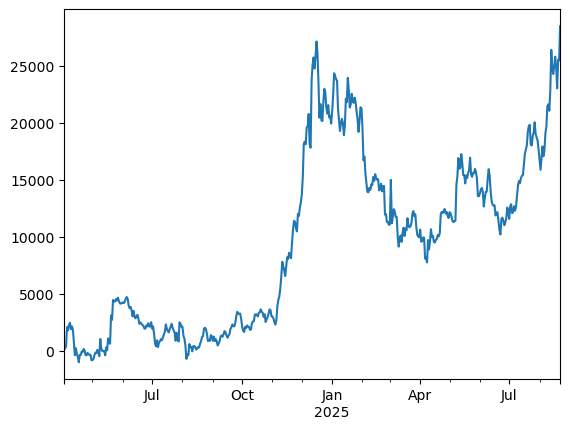

In [701]:
long['Daily PnL'].cumsum().plot()

In [672]:
long.head(3)

Ticker,AAVE-USD,ADA-USD,AVAX-USD,BNB-USD,BTC-USD,DOGE-USD,ENA-USD,ETH-USD,GAME-USD,LINK-USD,OKB-USD,SOL-USD,TRX-USD,WETH-USD,XRP-USD,Position Size,Daily PnL
2024-04-02,5.772786,1147.472652,14.238852,1.210621,0.010186,3656.895544,850.557108,0.203424,57885.442772,37.112637,11.670107,3.679739,5713.485883,0.203204,1138.694024,10000.000000,NaN
2024-04-03,5.958057,1197.177115,14.885418,1.216899,0.010365,3895.941854,607.041000,0.206533,59203.678541,38.625164,12.207413,3.691908,5832.467056,0.206158,1189.599364,10258.813789,258.813789
2024-04-04,5.981773,1194.215242,14.969248,1.189143,0.010162,3869.222772,712.075098,0.209059,50388.951335,39.124256,12.451370,3.784414,5841.559942,0.209216,1172.688806,10442.606246,183.792457


In [673]:
buy_hold = buy_hold_port(px, starting_cash=starting_long)
sortino(buy_hold)


1.5080069118096748

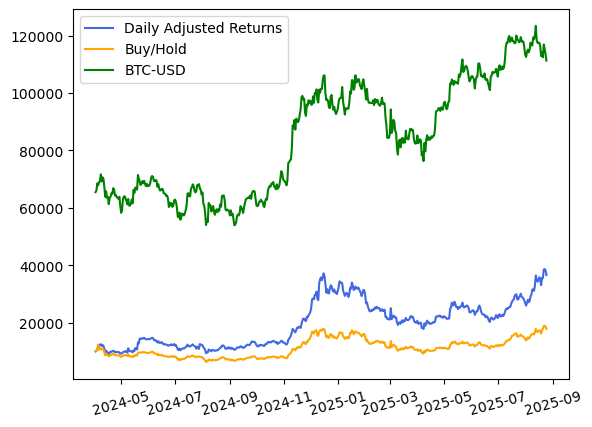

In [613]:
import matplotlib.pyplot as plt
plt.plot(long['Position Size'], label = 'Daily Adjusted Returns', color = 'royalblue')
plt.plot(buy_hold['Position Size'], label = 'Buy/Hold', color = 'orange')
plt.plot(px['BTC-USD'], label = 'BTC-USD', color = 'green')
plt.xticks(rotation=15)
plt.legend()
plt.show()

Evaluation

The strategy does better than buy/hold for cryptocurrencies, but slightly worse than buy/hold for the top 15 (trading vol) stocks in the SP500 (Not pictured, but easy to show). We can confirm this in out of sample data (Change start/end times). It performs with a robust sharpe ratio of 1.6 with a mean daily return of 34 bips with a std of 410 bips. I chose to annualize the sharpe with a factor of 365 since crypto markets remain open yearround (barring exchange-specific outages). Adjusted by a more common factor of 252, the SR drops to 1.33/ Not as strong but indicative of some risk control. Comparing with the sharpe of the buy/hold portfolio SR of 0.98 we can confirm that risk is handled better in a daily adjusted portfolio than a buy/hold. We can see this visually by comparing with drawdowns of simply holding BTC, the drawdowns in Daily Adjusted are more muted and smaller relative to portfolio size.

We're interested in the alpha of the strategy but first we discuss expectations. This strategy aims to rebalance a portfolio so that it doesn't become overweight in one token. Broadly speaking, this means that if the overall market goes down so does our portfolio. Therefore, we expect a high beta (>1) and a low alpha (approx. 0) because we are trying to follow a trend in the market while still outperforming in return space.

Finding Alpha

In [614]:
import statsmodels.api as sm
benchmark = 'BTC-USD'
strategy_ret = long['Position Size'].pct_change().dropna()
benchmark_ret = px[benchmark].pct_change().dropna()  # or any index

strategy_ret, benchmark_ret = strategy_ret.align(benchmark_ret, join='inner')

# Add constant for intercept
X = sm.add_constant(benchmark_ret)

# Run regression
model = sm.OLS(strategy_ret, X).fit()
print(model.summary())

# Extract alpha and beta
alpha = model.params['const']
beta = model.params[benchmark]
print(f"Alpha: {alpha}, Beta: {beta}")


                            OLS Regression Results                            
Dep. Variable:          Position Size   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     612.0
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           2.95e-89
Time:                        09:39:09   Log-Likelihood:                 1107.0
No. Observations:                 510   AIC:                            -2210.
Df Residuals:                     508   BIC:                            -2202.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.403      0.1

Interpretation

As expected we have a beta of 1.22 and an alpha of 0.0017 (annualized to 0.63). This means that the portfolio outperforms the market in a bull market and underperforms in a bear. It is not indicative of edge. The alpha is tempting but is likely to be eaten away by trading fees. Also, a t-stat of 1.4 is fairly inconclusive. 

This supports our hypothesis that a daily readjusted portfolio can help increase returns if the owner expects the overall market to increase in value, but performance is fundamentally tied to the overall market. This is further supported by an R^2 of approx. 0.55 meaning 55% of the variance in our portfolio is explained by the returns of BTC-USD.

Improvements

Our current strategy is to 100% long 15 tokens. This fundamentally ties our performance to that of the underlying token. Given the volatility in the crypto space this punishes our portfolio with frequent drawdowns that reduces risk-adjusted returns. To get around this, we will introduce a long-short strategy that longs 100% and shorts x% of starting cash. 

In [615]:
def short_port(px, long, starting_cash=1e4, interval=1, x = 0.5):

    # |---------UNFINISHED---------|
    
    # want to look at yesterdays long and short x% today

    n_assets = len(px.columns)
    standard_wt = 1 / n_assets
    current_cash = 0

    # Initialize portfolio: equal allocation in units
    initial_allocation = starting_cash * standard_wt * x # this is the main difference
    product_port = pd.DataFrame(
        [[initial_allocation / px.iloc[0][col] for col in px.columns]],
        columns=px.columns,
        index=[px.index[0]]
    )
    product_port['Position Size'] = starting_cash

    trades = []

    def calculate_wts(port, px, i):
        value = port.iloc[-1] * px.iloc[i]
        total = value.sum()
        return value / total

    # create set of dates to check
    dates = set(px.index[::interval])

    for i in range(1, len(px)):
        temp_port = long.iloc[[-1]].copy() * x  # start from yesterday's holdings and short x%
        temp_port.index = [px.index[i]]
        wts = calculate_wts(product_port, px, i)

        # Rebalance only if weights are not equal on days in dates
        if (wts.nunique() != 1) and (px.index[i] in dates):
            for j in px.columns:
                # Sell if overweight
                if wts[j] > standard_wt:
                    corrective_factor = wts[j] / standard_wt
                    remaining_amnt = temp_port[j].values[0] / corrective_factor
                    sell_amount = temp_port[j].values[0] - remaining_amnt
                    revenue = sell_amount * px.iloc[i][j]
                    current_cash += revenue
                    temp_port[j] = remaining_amnt

                    trades.append({
                        'Date': px.index[i],
                        'Asset': j,
                        'Type': 'SHORT',
                        'Price': px.iloc[i][j],
                        'Units': sell_amount,
                        'Revenue': -revenue
                    })

                # SELL if underweight, this is the short
                elif wts[j] < standard_wt:
                    corrective_factor = wts[j] / standard_wt
                    remaining_amnt = temp_port[j].values[0] / corrective_factor
                    buy_amount = remaining_amnt - temp_port[j].values[0]
                    cost = buy_amount * px.iloc[i][j]
                    current_cash -= cost
                    temp_port[j] = remaining_amnt

                    trades.append({
                        'Date': px.index[i],
                        'Asset': j,
                        'Type': 'SHORT',
                        'Price': px.iloc[i][j],
                        'Units': buy_amount,
                        'Revenue': cost
                    })

            # Reinvest any leftover cash
            if current_cash != 0:
                redis_cash = current_cash / n_assets
                for k in px.columns:
                    temp_port[k] += redis_cash / px.iloc[i][k]
                current_cash = 0

        # Append today's updated portfolio
        running_pos_size = (temp_port.iloc[0] * px.iloc[i]).sum()
        temp_port['Daily PnL'] = running_pos_size - product_port.iloc[-1]['Position Size']
        product_port = pd.concat([product_port, temp_port])
        
        product_port.at[product_port.index[-1], 'Position Size'] = running_pos_size

    trades_df = pd.DataFrame(trades).fillna(0)
    return product_port, trades_df



In [666]:
#short, short_trades = short_port(px)


In [667]:
#short['Position Size'].plot()

In [722]:
# let's do something clever
short = buy_hold
x = 0.8
short = -x * short

combined_rets = pd.DataFrame()
combined_rets['Daily PnL'] = long['Daily PnL'] + short['Daily PnL']
combined_rets['Position Size'] = long['Position Size'] + short['Position Size']
combined_rets['Return%'] = combined_rets['Position Size'].pct_change().dropna()
sortino(combined_rets)

4.882814921370728

In [723]:
combined_rets['Return%'].mean() / combined_rets['Return%'].std() * np.sqrt(365) # sharpe


2.0676654206033307

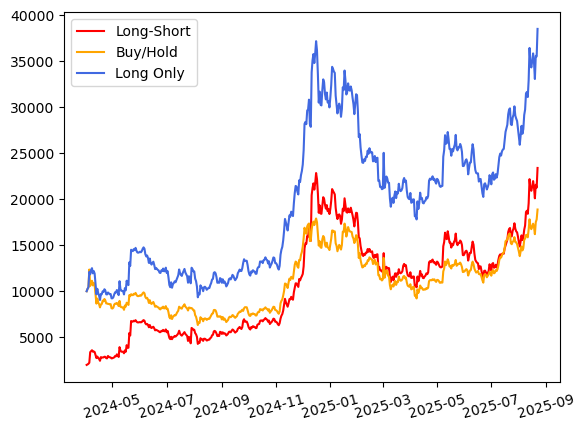

In [711]:
plt.plot(combined_rets['Position Size'], color = 'red', label= 'Long-Short')
plt.plot(buy_hold['Position Size'], label = 'Buy/Hold', color = 'orange')
plt.plot(long['Position Size'], label = 'Long Only', color = 'royalblue')
plt.xticks(rotation=15)
plt.legend()
plt.show()

Comparison

In [724]:
benchmark = 'BTC-USD'
strategy_ret = combined_rets['Return%']
benchmark_ret = px[benchmark].pct_change().dropna()  

strategy_ret, benchmark_ret = strategy_ret.align(benchmark_ret, join='inner')

# Add constant for alpha
X = sm.add_constant(benchmark_ret)

# Run regression
model = sm.OLS(strategy_ret, X).fit()
print(model.summary())

# Extract alpha and beta
alpha = model.params['const']
beta = model.params[benchmark]
print(f"Alpha: {alpha}, Beta: {beta}")

                            OLS Regression Results                            
Dep. Variable:                Return%   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     240.0
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           1.44e-44
Time:                        15:54:26   Log-Likelihood:                 810.73
No. Observations:                 507   AIC:                            -1617.
Df Residuals:                     505   BIC:                            -1609.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.050      0.0

In [715]:
strategy_ret.mean() * len(strategy_ret)

1.7159870848343646

In [720]:
buy_hold['Position Size'].mean() / starting_long

1.1087585944085754

Evaluation pt.2

|---------UNFINISHED---------|

Now that we've included a short position, the R^2 drops to 0.322 (was 0.546), so only 32% of the variance is explained by BTC-USD. This feels high. Further improvements could be to underweight BTC-USD by limiting (in dollar space) how much of the port could be placed in it. The alpha and beta terms have very high statistical significance. With an annualized alpha of 1.65, we know that this strategy generates signifcant excess returns.

In [686]:
excess_ret = strategy_ret - benchmark_ret
IR = excess_ret.mean() / excess_ret.std() # daily IR, annualize to 252
IR * np.sqrt(252)



1.1372037352677382

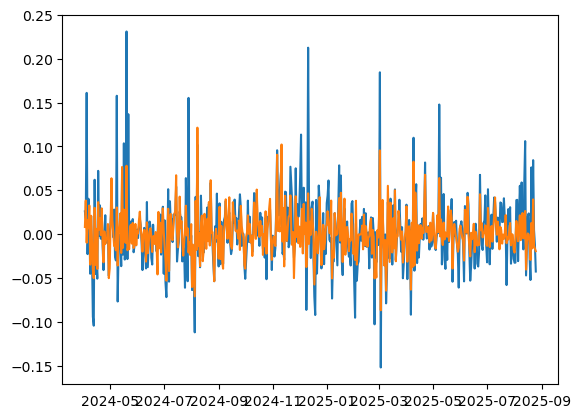

In [688]:
import matplotlib.pyplot as plt
plt.plot(strategy_ret)
plt.plot(benchmark_ret)
plt.show()

In [689]:
strategy_ret.corr(benchmark_ret)

0.7392031386660392

Trading costs

In [687]:
# same assumptions as in corr_trading_strat, 7 bps slippage, 15 trades a day, 365 days a year, this is long only
strategy_ret.mean() - 0.0007*len(px.columns)*len(strategy_ret)

-5.351635319441502

Doesn't survive trading costs

In [ ]:
def drawdown(port):
    cumrets = port['Position Size'] / port.iloc[0]['Position Size']
    running_max = cumrets.cummax()
    drawdown = (running_max - cumrets) / running_max
    
    return drawdown

<Axes: >

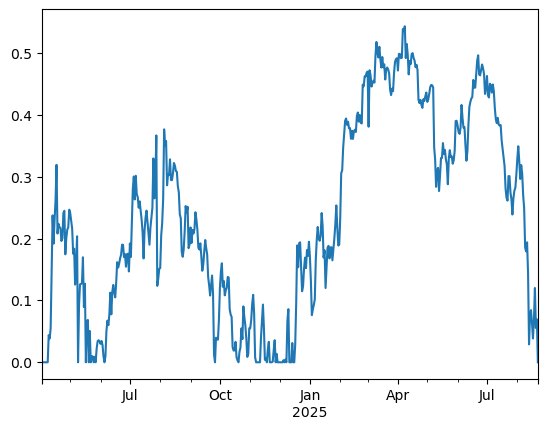

In [679]:
drawdown(combined_rets).plot()